# Create LossTanGram, Production Code

## User input

In [5]:
#### SPECIFY FILEPATHS
# if exporting data from SeisWare, use IBM trace data format, generic-segy header,
# Unix byte order, and set keywords to 32 bit integer

# filename is input 2D radargram
# LossTangent is the container that will be overwritten with Loss Tangent values

Radargram = ("C:\\Users\\User\\Desktop\\Radar\\SEGY\\1000902000_Unix_IBM32.sgy")
LossTangent = ("C:\\Users\\User\\Desktop\\Radar\\SEGY\\1000902000_LossTan.sgy")
LossTangentDeriv = ("C:\\Users\\User\\Desktop\\Radar\\SEGY\\1000902000_LossTanDerivative.sgy")

# Need to add column to surface return csv file: 4th column is surface return value *1000 to remove decimals
# NO HEADER LINE IN FILE, format as X, Y, Surface Return, Surface Return *1000
Surface_Return = ("C:\\Users\\User\\Desktop\\Radar\\SEGY\\Horizons\\Surface_1000902000.csv")

#### REQUIRED PARAMETERS

# pick center frequency in Hertz
f = 20000000

# set sample number for RMS window
S = 5

## Run Calculations

In [7]:
#### IMPORT LIBRARIES
import numpy as np
import segyio
import bruges
from shutil import copyfile
import itertools


#### CREATE LOSSTANGRAM AND DERIVATIVE
# copy input data to create files with proper headers
copyfile(Radargram, LossTangent)

# For use in writing surface return to header
# Need to add column to surface return csv file: 4th column is return value *1000 to remove decimals
# NO HEADER LINE IN FILE, format as X, Y, Surface Return, Surface Return *1000
input_horz = open(Surface_Return, 'r')
surf_horz = np.loadtxt(input_horz,delimiter=',')
horizon = {}
for ln in surf_horz:
    horizon[(int(ln[0]), int(ln[1]))] = int(ln[3])
Xco = np.array([], dtype='int32')
Yco = np.array([], dtype='int32')

#Write surface return into header
with segyio.open(LossTangent, "r+", ignore_geometry=True) as LossTan:
    for i in range(len(LossTan.trace)):
        Xco = np.append(Xco, int(LossTan.header[i][segyio.TraceField.GroupX]))
        Yco = np.append(Yco, int(LossTan.header[i][segyio.TraceField.GroupY]))
    coords = list(zip(Xco, Yco))
    for i, coord in enumerate(coords):
        try:
            LossTan.header[i][segyio.TraceField.SourceEnergyDirectionMantissa] = int(horizon[coord])
        except:
            LossTan.header[i][segyio.TraceField.SourceEnergyDirectionMantissa] = 0
    for i in range(len(LossTan.trace)):
        if LossTan.header[i][segyio.TraceField.SourceEnergyDirectionMantissa] == 0:
            try:
                LossTan.header[i][segyio.TraceField.SourceEnergyDirectionMantissa] = int((LossTan.header[i-1][segyio.TraceField.SourceEnergyDirectionMantissa] + LossTan.header[i+1][segyio.TraceField.SourceEnergyDirectionMantissa])/2)
            except:
                LossTan.header[i][segyio.TraceField.SourceEnergyDirectionMantissa] = 0

                
# calculating loss Tangent
    all_traces = segyio.tools.collect(LossTan.trace[:])
    MinVal = np.nanmin(all_traces)
    Samples = LossTan.samples
    for i in range(len(LossTan.trace)):
        header = LossTan.header[i]

        #RMS calculation
        Bias = LossTan.trace[i] - MinVal
        tr = bruges.filters.filters.rms(Bias, S)

#Calculating Loss Tangent
        if header[segyio.TraceField.SourceEnergyDirectionMantissa] == 0:
            tr.fill(0)
            Po = 0
        else:
            Surface_index = np.abs((Samples) - (header[segyio.TraceField.SourceEnergyDirectionMantissa]/1000)).argmin()
            Po = tr[Surface_index]
        if Po == 0:
            tr.fill(0)
        else:
            time_diff = ((Samples)/10000000)-((Surface_index*0.375)/10000000)
            log_term = tr[(Surface_index+1):]/Po
            tr[:(Surface_index+2)] = 0
            tr[(Surface_index+1):] = (1/(2*np.pi*f))*(-1/time_diff[(Surface_index+1):])*np.log(log_term)
            LossTan.trace[i] = tr
            
            
#Calculating derivative
copyfile(LossTangent, LossTangentDeriv)
with segyio.open(LossTangentDeriv, "r+",ignore_geometry=True) as LTderiv:
    for i in range(len(LTderiv.trace)):
        tr = LTderiv.trace[i]
        LTderiv.trace[i] = np.gradient(tr)

## Plots

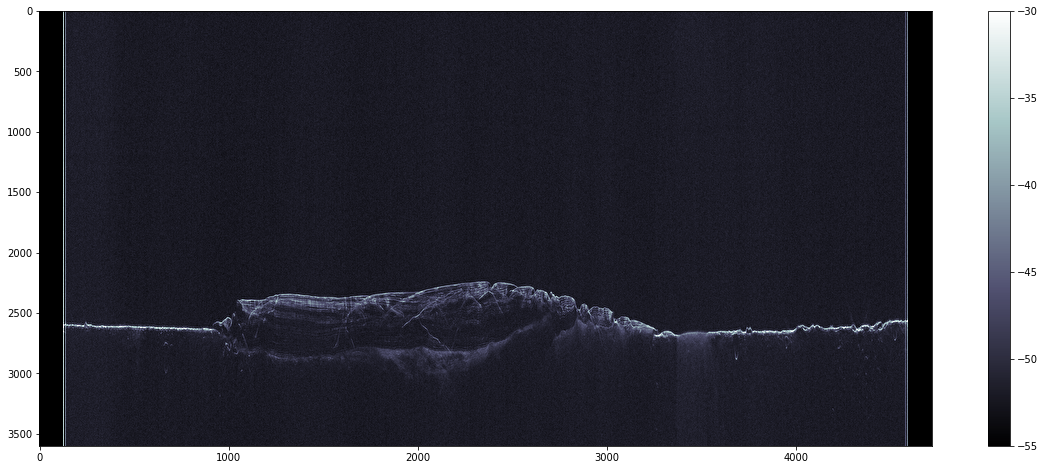

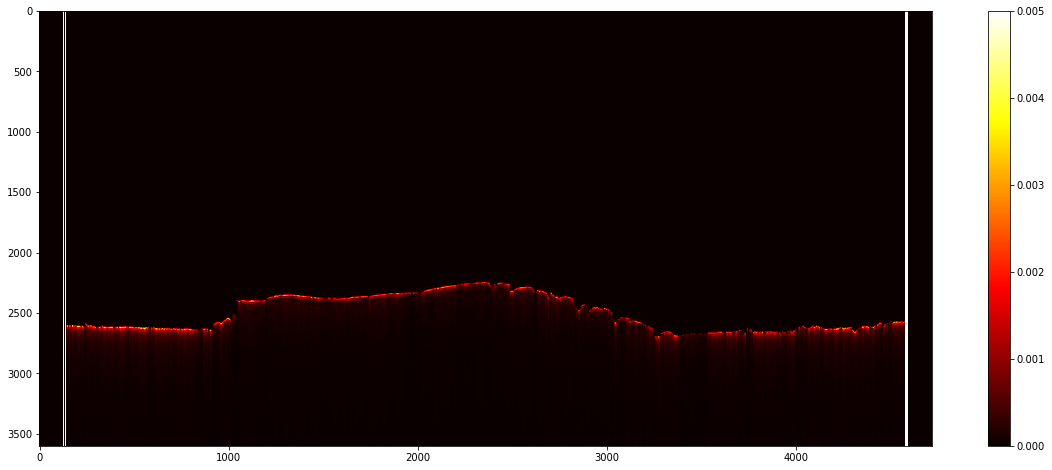

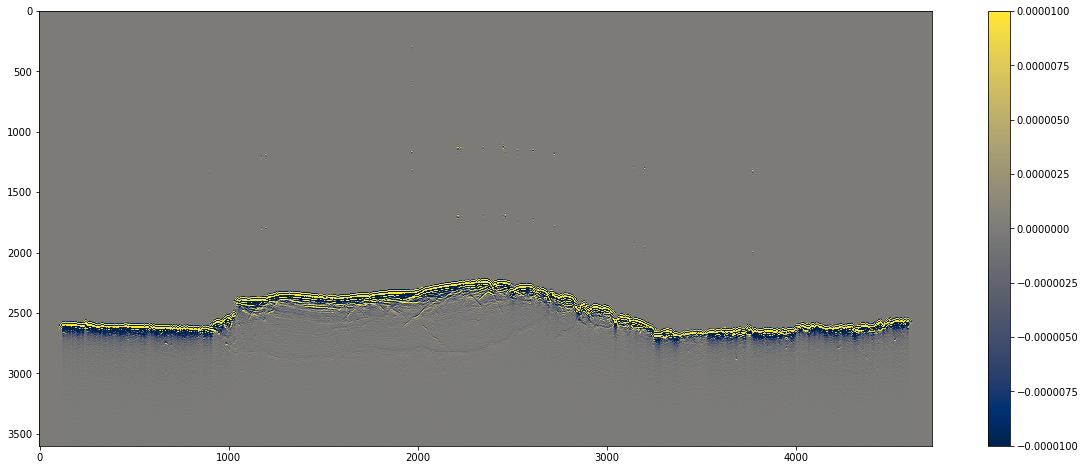

In [14]:
import segyio
import matplotlib.pyplot as plt

with segyio.open(Radargram, "r",ignore_geometry=True) as segyfile:
    all_traces = segyio.tools.collect(segyfile.trace[:])
plt.figure(figsize=(20,8))
#plt.ylim(3600,1500)
#plt.xlim(,)
plt.imshow(all_traces.T, cmap="bone", vmin=-55, vmax=-30, aspect='auto', interpolation='sinc')
plt.colorbar()
#plt.text(250,1700,'Observation Number: 1000902000', color='white', fontsize = 15)
plt.show()

with segyio.open(LossTangent, "r",ignore_geometry=True) as LossTan:
    all_traces = segyio.tools.collect(LossTan.trace[:])
plt.figure(figsize=(20,8))
#plt.ylim(3600,1500)
#plt.xlim(,)
plt.imshow(all_traces.T, cmap="hot", vmin=0, vmax=0.005, aspect='auto', interpolation='sinc')
plt.colorbar()
#plt.text(250,1700,'Observation Number: 1000902000', color='white', fontsize = 15)
plt.show()

with segyio.open(LossTangentDeriv, "r",ignore_geometry=True) as LTderiv:
    all_traces = segyio.tools.collect(LTderiv.trace[:])
plt.figure(figsize=(20,8))
#plt.ylim(3600,1500)
#plt.xlim(,)
plt.imshow(all_traces.T, cmap="cividis", vmin=-0.00001, vmax=0.00001, aspect='auto', interpolation='sinc')
plt.colorbar()
#plt.text(250,1700,'Observation Number: 1000902000', color='white', fontsize = 15)
plt.show()